# 机器学习-基于CNN的青光眼检测模型
<br>
小组成员：2022217940潘序（组长），2022218057梁禹，2022218605万立志，2022218058方宇豪
<br>
GPU: NVIDIA GeForce RTX 4090<br>
OS: Ubuntu 20.04<br>
Python: 3.8<br>

## 一、模型背景
青光眼，作为一种导致不可逆视力丧失的眼科疾病，在全球范围内对人类健康构成了重大威胁。<br>
据估计，到2020年，全球将有超过1100万人因青光眼而失明。鉴于其早期症状不明显，早期诊断对于预防视力损害至关重要。<br>
然而，专业眼科医生的缺乏，尤其是在偏远地区，限制了青光眼的早期筛查和治疗。<br>
为了解决这一问题，我们小组设计了一种基于卷积神经网络（CNN）的青光眼眼底病变检测模型——EyeNet。<br>
<br>
数据集链接：[Fundus Glaucoma Detection Data [PyTorch format]](https://www.kaggle.com/datasets/sabari50312/fundus-pytorch "Fundus Glaucoma Detection Data [PyTorch format]")<br>
Github：[EyeNet: A Convolutional Neural Network for Glaucomatous Fundus Lesion Detection](https://github.com/JerryP-hfut/EyeNet-A-Convolutional-Neural-Network-for-Glaucomatous-Fundus-Lesion-Detection "EyeNet-A-Convolutional-Neural-Network-for-Glaucomatous-Fundus-Lesion-Detection")<br>
(2022218057梁禹)

## 二、环境测试
测试当前环境是否可用GPU训练。<br>
(2022217940潘序)

In [13]:
import torch
print(torch.__version__)  # 查看torch当前版本号
print(torch.version.cuda)  # 编译当前版本的torch使用的cuda版本号
print(torch.cuda.is_available())  # 查看当前cuda是否可用于当前版本的Torch，如果输出True，则表示可用

2.3.0+cu118
11.8
True


## 三、模型结构
![model](https://gitee.com/jerry-ethan-pan/EyeNet-A-Convolutional-Neural-Network-for-Glaucomatous-Fundus-Lesion-Detection/raw/main/demo/construct.png)<br>
(作图：2022217940潘序)<br>
在EyeNet中，卷积层由多个Conv2d层组成，负责提取输入图像的特征。<br>
第一个卷积层将输入通道数从3（RGB图像）增加到64，使用3x3的卷积核;<br>
第二个卷积层将通道数从64增加到128;<br>
第三个卷积层保持通道数为128;<br>
第四个卷积层将通道数从128增加到256;<br>
第五个卷积层保持通道数为256。<br>
每个卷积层后面都紧跟一个ReLU激活函数，用于引入非线性。<br>
<br>
EyeNet中的池化层用于降低特征图的空间维度，以减少计算量并增加感受野，同时也提高了模型对小的位置变化的不变性。<br>
在EyeNet中，池化层使用了2x2的池化核和2的步长，使得输出为输入大小的1/4。<br>
<br>
除了最后一个卷积层，ReLU激活函数在EyeNet的每个卷积层后面使用，这是因为ReLU能够在训练过程中提供快速的收敛速度，并且减轻梯度消失的问题。<br>
(2022217940潘序)

In [14]:
import torch
import torch.nn as nn

class EyeNet(nn.Module):
    def __init__(self):
        super(EyeNet,self).__init__()
        self.Conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 ,stride=2),
            
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classify = nn.Sequential(
            nn.Linear(25*25*256,512),
            nn.ReLU(),
            torch.nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(128,1)
        )
    def forward(self,x):
        x = self.Conv(x)
        x = x.view(-1, 25 * 25 * 256)
        x = self.classify(x)
        return x

打印模型结构：

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
md = EyeNet().to(device)
print(md)

EyeNet(
  (Conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_feature

## 四、数据集加载器
本模块包含了一个最基本的PyTorch的数据集加载器和一个getROI(image)函数。<br>

### （一）相关库的引入

In [16]:
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

### （二）getROI(image)函数
 经过小组查阅资料，青光眼病变时医生通常根据眼底图像，一般是后视网膜图像中的眼底视盘区域的形状改变进行诊断。<br>
 这块区域在图像中呈现的是一个明显的偏亮的圆形或椭圆形区域。<br>
 因此，我们使用getROI函数，找到图像中平均像素值最高的一个200x200区域并返回。<br>
 这是一种数据增强的方式，我们小组通过这种方法大大缩短了神经网络的训练时间，并且能够防止模型的过拟合。<br>
 (2022218057梁禹)<br>
 getROI()函数示意图如下:<br>
![getroi](https://gitee.com/jerry-ethan-pan/EyeNet-A-Convolutional-Neural-Network-for-Glaucomatous-Fundus-Lesion-Detection/raw/main/demo/enhance.png)<br>
(作图：2022218057梁禹)<br>

In [17]:
def getROI(image):
    if isinstance(image, Image.Image):
        image = np.array(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

    max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), gray_image.shape)
    radius = 200 // 2
    x = max_intensity_pixel[1] - radius
    y = max_intensity_pixel[0] - radius
    x = max(0, x)
    y = max(0, y)
    square_size = 2 * radius
    mask = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)
    cv2.rectangle(mask, (x, y), (x + square_size, y + square_size), (255, 255, 255), -1)
    roi_image = cv2.bitwise_and(image, mask)
    cropped_roi = roi_image[y:y+square_size, x:x+square_size]
    resized_roi = cv2.resize(cropped_roi, (square_size, square_size))
    
    return resized_roi

### （三）PyTorch数据集加载器GlaucomaDataset(Dataset)
 根据数据集的摆放方式创建图像-标签表供模型训练和评估。PyTorch规定了这一类的编写方法。(2022218057梁禹)

In [18]:
class GlaucomaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # 获取所有图像的路径和标签
        self.images = []
        self.labels = []
        for label in [0, 1]:
            label_dir = os.path.join(self.data_dir, str(label))
            for img_file in os.listdir(label_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(label_dir, img_file))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
       # 加载图像
        image = Image.open(self.images[idx]).convert('RGB')  # 确保图像是RGB格式
        # 应用自定义的getROI函数
        image = getROI(image)
        # 应用转换操作
        if self.transform:
            image = self.transform(image)
    
        # 标签
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

## 五、训练模式
### （一）我们使用了：<br>
1、学习率：首先设置为0.01，发现模型loss几乎不下降，于是逐步降低至0.0001发现模型loss下降，且在测试集的正确率上升。最后训练到模型准确率到95%左右时发现loss和accuracy都停滞，于是继续减小学习率，直至模型历史正确率高达98.56%。<br>
2、损失函数：由于我们拟解决的是一个二分类问题，于是我们使用了二元交叉熵损失函数。<br>
3、优化器：我们使用了Adam优化器，来优化反向传播时参数调整的过程。<br>
<br>
前期工作结果: <br>
训练至第150 epoch的模型（准确率98.56%），其历史准确率折线图如下：<br>
![accuracy](https://gitee.com/jerry-ethan-pan/EyeNet-A-Convolutional-Neural-Network-for-Glaucomatous-Fundus-Lesion-Detection/raw/main/demo/AccuracyCurve.png)<br>
(作图：2022217940潘序)<br>
在第30epoch训练完毕后，发现准确度不上升，调整学习率后发现准确率高速上升。<br>
(2022217940潘序)

In [19]:
import torch
import os
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from models import model
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils.dataLoader import GlaucomaDataset

import predict

# 数据集路径
data_dir = 'datas/archive'
learning_rate = 0.00001 #学习率在训练过程中更改
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为PyTorch张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) #归一化操作

train_dataset = GlaucomaDataset(os.path.join(data_dir, 'train'), transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

md = model.EyeNet().cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = optim.Adam(md.parameters(),lr = learning_rate)

### （二）train(pre_epochs, epochs)函数：
首先看train函数输入，如果不是从0 epoch开始训练的则使用预训练的权重。然后使用数据集加载器加载的图像-标签对，对模型进行训练。具体的训练过程依次包括梯度归零、前向传播计算输出、损失函数计算、反向传播和优化器优化。<br>
每一个epoch训练完毕后保存一次模型，并且调用下一个Cell中的eva()函数，使用本epoch的模型对测试集图像标签对进行准确率评估。如果本epoch训练的结果模型准确度创下整个训练过程的历史记录，则将本模型保存为best model。<br>
(2022217940潘序)

epoch= 150
Epoch [150/151], Step [10/270], Loss: 0.0883
Epoch [150/151], Step [20/270], Loss: 0.0182
Epoch [150/151], Step [30/270], Loss: 0.0522
Epoch [150/151], Step [40/270], Loss: 0.0222
Epoch [150/151], Step [50/270], Loss: 0.0146
Epoch [150/151], Step [60/270], Loss: 0.0017
Epoch [150/151], Step [70/270], Loss: 0.0131
Epoch [150/151], Step [80/270], Loss: 0.0235
Epoch [150/151], Step [90/270], Loss: 0.0111
Epoch [150/151], Step [100/270], Loss: 0.0020
Epoch [150/151], Step [110/270], Loss: 0.0213
Epoch [150/151], Step [120/270], Loss: 0.0128
Epoch [150/151], Step [130/270], Loss: 0.0399
Epoch [150/151], Step [140/270], Loss: 0.0221
Epoch [150/151], Step [150/270], Loss: 0.0149
Epoch [150/151], Step [160/270], Loss: 0.0090
Epoch [150/151], Step [170/270], Loss: 0.0322
Epoch [150/151], Step [180/270], Loss: 0.0039
Epoch [150/151], Step [190/270], Loss: 0.0372
Epoch [150/151], Step [200/270], Loss: 0.0097
Epoch [150/151], Step [210/270], Loss: 0.0623
Epoch [150/151], Step [220/270],

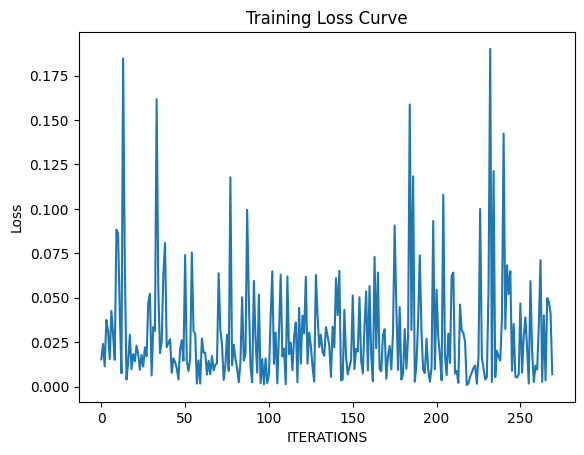

In [20]:
def train(pre_epochs, epochs):
    losses = []
    accuracies = []
    max_accuracy = 0
    # 如果预训练过了就加载已有权重
    if pre_epochs >= 1:
        md.load_state_dict(torch.load('check_point.pth'))
    for epoch in range(pre_epochs, epochs):
        print("epoch=",epoch)
        for i,(features,label) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = md(features.cuda())
            outputs = outputs.squeeze()
            loss = criterion(outputs, label.float().cuda())
            loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, epochs, i+1, len(train_loader), loss.item()))
            losses.append(loss.item())
        torch.save(md.state_dict(), 'check_point.pth') #每一个epoch训练结束保存一次模型
        acc = predict.eva()
        accuracies.append(acc)
        if acc > max_accuracy:
            max_accuracy = acc
            torch.save(md.state_dict(), f'best_model.pth')
    plt.plot(losses)
    plt.xlabel("ITERATIONS")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")  
    plt.show()

#     plt.plot(accuracies)
#     plt.xlabel("ITERATIONS")
#     plt.ylabel("Accuracy")
#     plt.title("Accuracy Curve")
#     plt.show()
    
if __name__ == '__main__':
    train(150,151) #跑一个epoch作为示例

## 六、评估模式（隐藏模式）
本模式只能由train(pre_epochs, epochs)函数调用，不可由使用者直接调用。<br>
如果想对单张图片进行青光眼诊断，则可以使用下一Cell的diagnose()函数。<br>(2022217940潘序)<br>

In [53]:
def eva():
    md = model.EyeNet().cuda()
    md.load_state_dict(torch.load("check_point.pth"))
    md.eval()

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    data_dir = 'datas/archive'
    test_dataset = GlaucomaDataset(os.path.join(data_dir, 'test'), transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    close_count = 0
    total = 0
    tolerance = 0.5
    with torch.no_grad():
        for features, label in test_loader:
            output = md(features)
            output = output.squeeze()
            total += label.size(0)
            difference = torch.abs(output - label.squeeze())
            close_count += (difference <= tolerance).sum().item()
    if total > 0:
        close_ratio = close_count / total
        print('Percentage of predictions within 0.2 of true value: {:.2f}%'.format(close_ratio*100.0))
        return close_ratio
    else:
        print('No samples to evaluate.')

## 七、诊断模式（直接调用模式）
可以通过本模式，对指定的图像，使用我们的最高准确率模型进行青光眼诊断。<br>
本Cell中使用了数据集中archive/val中的后视网膜图像，并且取出其中8张进行诊断结果可视化。<br>
(2022217940潘序)<br>

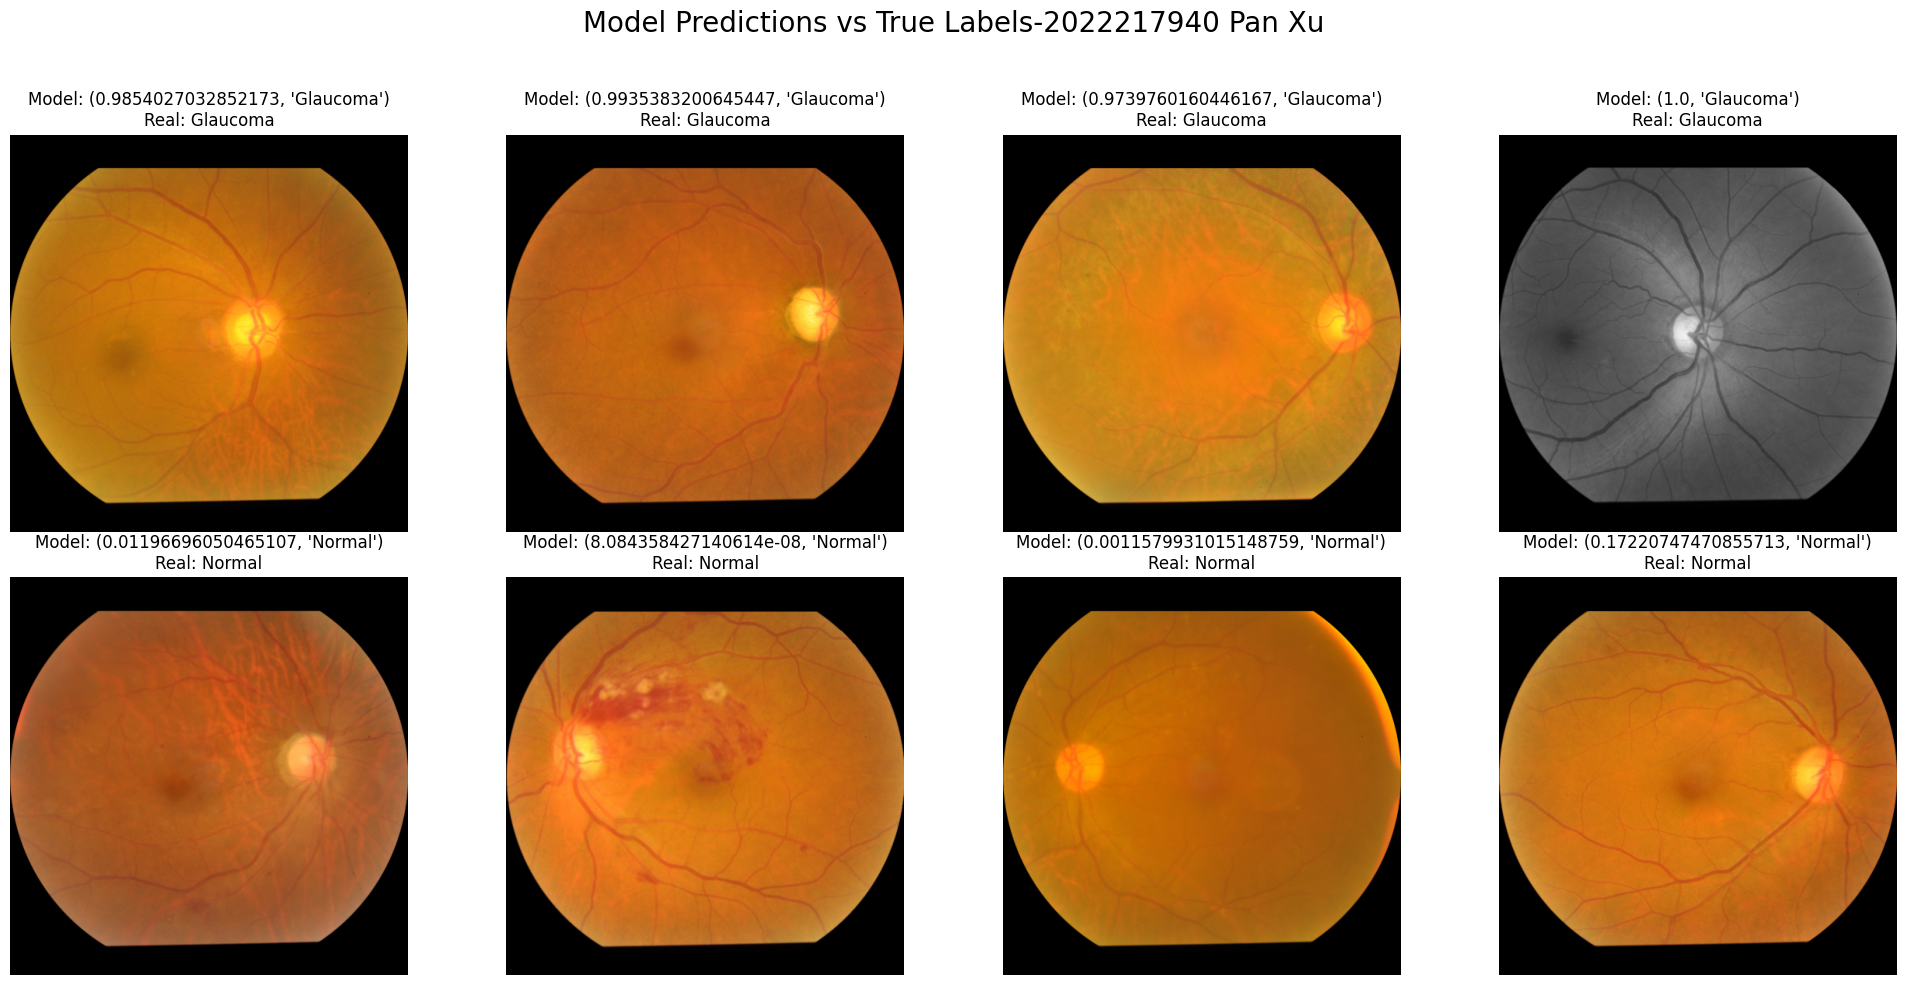

In [63]:
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from models import model
from utils import dataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

def diagnosis(path, md, transform):
    md.eval()  # 模型处于评估模式（不训练）

    img = Image.open(path).convert('RGB')  # 确保图片是RGB格式
    img = dataLoader.getROI(img)
    img = transform(img)  # 应用转换操作
    img = torch.unsqueeze(img, 0)
    img = img.cuda()

    with torch.no_grad():
        output = md(img)
        output = output.squeeze()
        predicted_prob = torch.sigmoid(output)
        # 根据概率确定诊断结果
        diagnosis_result = 'Normal' if predicted_prob.item() < 0.5 else 'Glaucoma'
    return predicted_prob.item(), diagnosis_result

def visualize_results(results):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Model Predictions vs True Labels-2022217940 Pan Xu', fontsize=20)
    for i, (img_path, result, true_label) in enumerate(results):
        img = Image.open(img_path).convert('RGB')
        ax = axes[i // 4, i % 4]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Model: {result}\nReal: {'Glaucoma' if true_label == 1 else 'Normal'}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

md = model.EyeNet().cuda()
md.load_state_dict(torch.load("best_model.pth"))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
val_dir = 'datas/archive/val'
glaucoma_images = [os.path.join(val_dir, '1', img) for img in os.listdir(os.path.join(val_dir, '1'))[:4]]
normal_images = [os.path.join(val_dir, '0', img) for img in os.listdir(os.path.join(val_dir, '0'))[:4]]
    
results = []
    
for img_path in glaucoma_images:
    result = diagnosis(img_path, md, transform)
    results.append((img_path, result, 1))  # 1表示真实标签为青光眼阳性
    
for img_path in normal_images:
    result = diagnosis(img_path, md, transform)
    results.append((img_path, result, 0))  # 0表示真实标签为青光眼阴性
    
visualize_results(results)

## 可视化1：ROC曲线
ROC曲线常用于评估分类模型在不同阈值设置下的表现。它通过绘制真阳率（True Positive Rate, TPR）和假阳率（False Positive Rate, FPR）之间的关系来展示模型的性能。
### 真正例率（TPR）
TPR也称为召回率（Recall），是模型正确预测为正类的样本占所有实际正类样本的比例。
### 假正例率（FPR）
模型错误预测为正类的样本占所有实际负类样本的比例。<br>
<br>
ROC曲线下面积（Area Under the Curve, AUC）是一个常用的性能指标，AUC值越高，模型的分类性能越好。<br>
完美的分类器的AUC值为1，而一个随机猜测的分类器的AUC值接近0.5。<br>
(2022217058方宇豪)

In [64]:
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve-2022218058 Fang Yuhao')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

## 可视化2：混淆矩阵
混淆矩阵是一个表格，用于可视化模型预测结果与实际标签之间的关系。包含以下四个元素：<br>

(1)真正类（True Positives, TP）：模型正确预测为正类的样本数量。<br>
(2)假正类（False Positives, FP）：模型错误预测为正类的样本数量（实际上是负类）。<br>
(3)真负类（True Negatives, TN）：模型正确预测为负类的样本数量。<br>
(4)假负类（False Negatives, FN）：模型错误预测为负类的样本数量（实际上是正类）。<br>
(2022218058方宇豪)

In [75]:
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Glaucoma'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix-2022218605 Wan Lizhi')
    plt.savefig('confusionMat.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

## 可视化3：PR曲线
PR曲线也是一种评估分类模型性能的工具，它专注于正类的预测精度。<br>
<br>
(1)精确度（Precision），是模型正确预测为正类的样本占模型预测为正类的所有样本的比例。<br>
(2)召回率（Recall），如上所述，是模型正确预测为正类的样本占所有实际正类样本的比例。<br>
PR曲线通过绘制精确度和召回率之间的关系来展示模型的性能。
<br>
(2022218605万立志)

In [76]:
def plot_precision_recall_curve(true_labels, predicted_probs):
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
    plt.figure()
    plt.plot(recall, precision, marker='.', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve-2022218057Fang Yuhao')
    plt.savefig('preRecall.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

## 可视化4：Grad-CAM(梯度加权类激活映射)


(1)计算全局平均池化层的梯度：对于感兴趣的类别，计算模型最后一个卷积层的输出相对于该类别得分的梯度。这个梯度表示了特征图中每个位置对类别得分的贡献程度。<br>
(2)加权平均池化特征图：将上一步得到的梯度与最后一个卷积层的特征图相乘，然后对这些加权的特征图进行全局平均池化，得到一个二维的激活图。<br>
(3)上采样到输入图像大小：将二维激活图上采样到原始输入图像的大小。<br>
(4)可视化：将得到的二维激活图与原始图像相叠加，可以直观地看到模型在做出特定类别预测时，关注的是图像中的哪些区域。<br>
<br>
(2022218605万立志，2022217940潘序)

In [67]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from models import model
from utils import dataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        target = output[:, 0]
        target.backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()

        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[3], x.shape[2]))
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

def visualize_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_INFERNO)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img) / 255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

## 可视化5：t-SNE高维特征可视化
青光眼预测模型提取的是青光眼的高维特征，t-SNE能够将这种高维特征映射在一张二维散点图中，一个模型如果具有较好的分类性能，属于同一样本的点（颜色相同）应更加聚集，属于不同样本的点（颜色不同）应更加远离。<br>
t-SNE的原理如下：<br>
（1）高维空间的概率分布：在原始的高维空间中，t-SNE首先计算每个数据点与其邻居之间的相似度，并基于这些相似度构建一个概率分布，通常是高斯分布。<br>
（2）低维空间的概率分布：接着，t-SNE在低维（通常是二维或三维）空间中为每个数据点创建一个新的概率分布，这个分布基于高维空间中的概率分布。<br>
（3）优化过程：t-SNE通过最小化高维空间和低维空间概率分布之间的KL散度来优化数据点在低维空间中的映射。这个过程涉及到梯度下降等优化算法。<br>
（4）局部结构的保持：t-SNE特别强调保持数据点之间的局部结构，即相似的数据点在低维空间中应该彼此靠近，而不相似的数据点则应该彼此远离。<br>
(2022217940潘序)

In [68]:
def visualize_features_tsne(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.cuda()
            lbls = lbls.cuda()
            output = model.Conv(imgs)
            output = output.view(output.size(0), -1)
            features.append(output.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # t-SNE visualization
    perplexity = min(30, len(features) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette='viridis')
    plt.title('t-SNE of Features-2022217940 Pan Xu')
    plt.show()
    plt.savefig('TSNE.jpg', dpi=300, bbox_inches='tight', pad_inches=0)

## 可视化结果：
从val数据集中取出200张图片进行测试，并且将结果数据准备好。<br>
(2022217057梁禹)

In [69]:
# 实例化模型并加载权重
md = model.EyeNet().cuda()
md.load_state_dict(torch.load("best_model.pth"))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
val_dir = 'datas/archive/val'
num_images = 200  # 设置使用的图片数量
glaucoma_images = [os.path.join(val_dir, '1', img) for img in os.listdir(os.path.join(val_dir, '1'))[:num_images]]
normal_images = [os.path.join(val_dir, '0', img) for img in os.listdir(os.path.join(val_dir, '0'))[:num_images]]
    
results = []
true_labels = []
predicted_probs = []
predicted_labels = []
    
for img_path in glaucoma_images:
    prob, result = diagnosis(img_path, md, transform)
    results.append((img_path, result, 1))  # 1表示真实标签为青光眼阳性
    true_labels.append(1)
    predicted_probs.append(prob)
    predicted_labels.append(1 if prob >= 0.5 else 0)
    
for img_path in normal_images:
    prob, result = diagnosis(img_path, md, transform)
    results.append((img_path, result, 0))  # 0表示真实标签为青光眼阴性
    true_labels.append(0)
    predicted_probs.append(prob)
    predicted_labels.append(1 if prob >= 0.5 else 0)

## ROC曲线

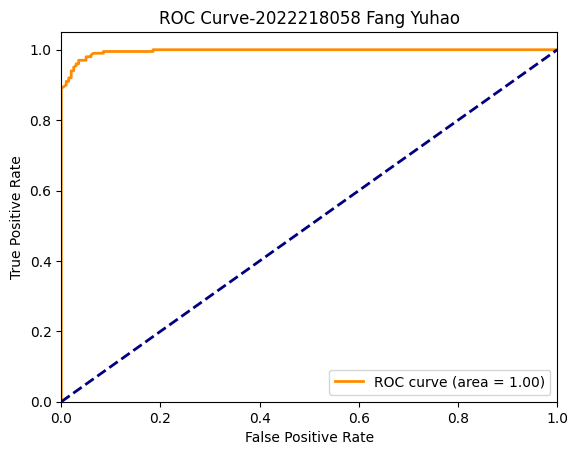

In [70]:
plot_roc_curve(true_labels, predicted_probs)

## 混淆矩阵

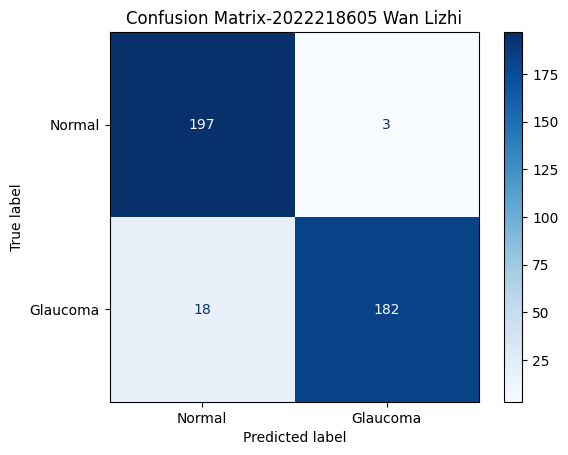

In [77]:
plot_confusion_matrix(true_labels, predicted_labels)

## PR曲线

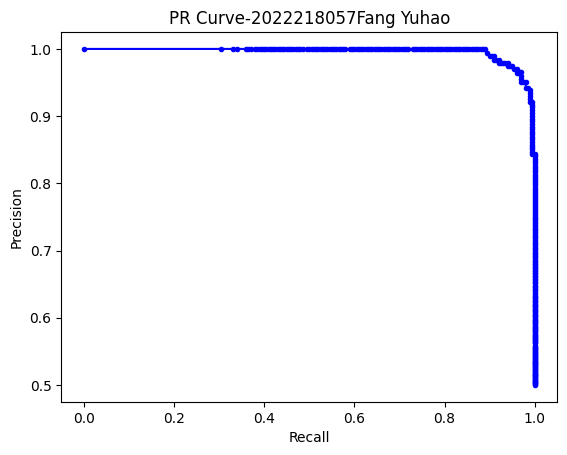

In [78]:
plot_precision_recall_curve(true_labels, predicted_probs)

## Grad-CAM(梯度加权类激活映射)

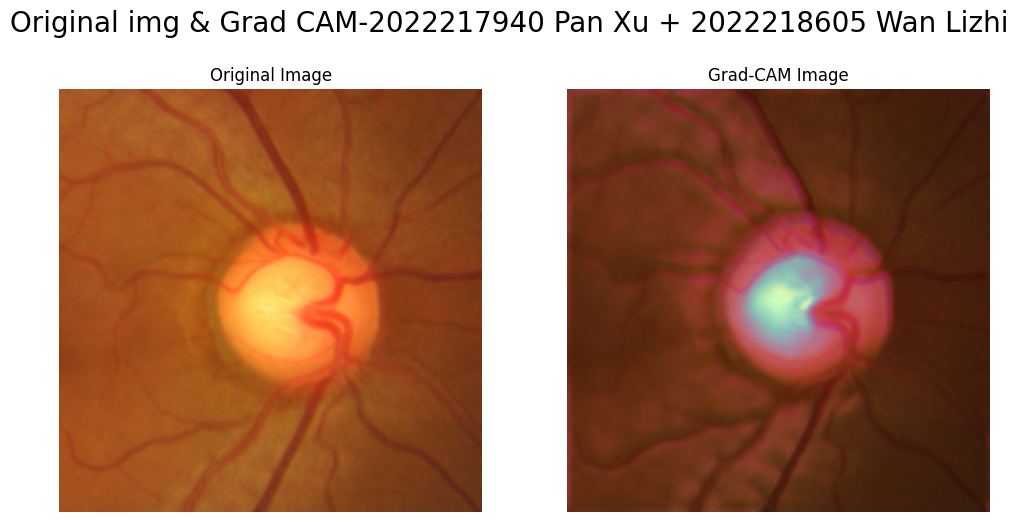

In [73]:
target_layer = md.Conv[6]  # 最后一个卷积层
grad_cam = GradCAM(md, target_layer)

img_path = "demo/resizedROI.png"
original_img = Image.open(img_path).convert('RGB')
img_array = np.array(original_img)

img = dataLoader.getROI(original_img)
img = transform(img).unsqueeze(0).cuda()

cam = grad_cam(img)
cam_img = visualize_cam_on_image(img_array, cam)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_array)
ax[0].set_title('Original Image')
ax[0].axis('off') 

ax[1].imshow(cam_img)
ax[1].set_title('Grad-CAM Image')
ax[1].axis('off') 
fig.suptitle('Original img & Grad CAM-2022217940 Pan Xu + 2022218605 Wan Lizhi', fontsize=20)
plt.show()

## t-SNE高维特征可视化

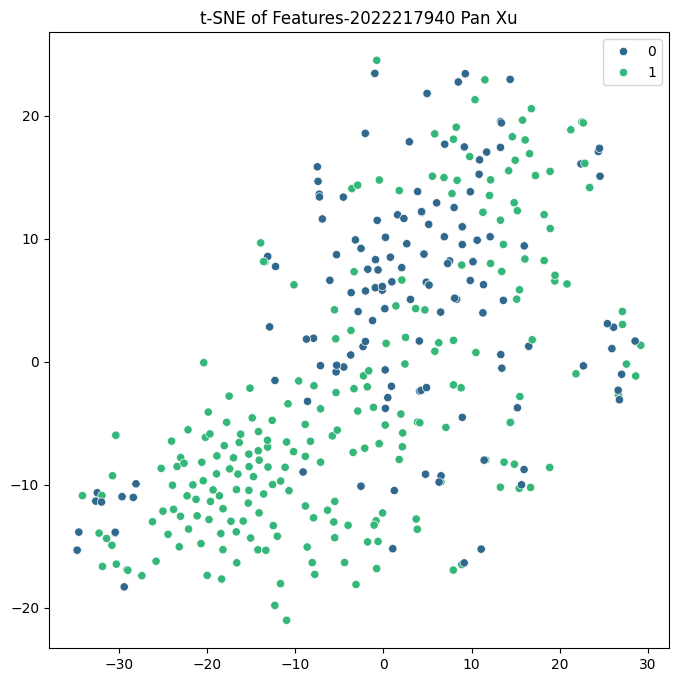

<Figure size 640x480 with 0 Axes>

In [74]:
import seaborn as sns
from sklearn.manifold import TSNE

val_dataset = []
for img_path in glaucoma_images + normal_images:
    img = Image.open(img_path).convert('RGB')
    img = dataLoader.getROI(img)
    img = transform(img)
    label = 1 if '1' in img_path else 0
    val_dataset.append((img, label))
    
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False)
visualize_features_tsne(md, val_loader)